<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/segment_anything_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3jtpx767
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3jtpx767
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=113df6cade7697484637f2b11945d4e3a61bebc6247e1850dce15dec81de3069
  Stored in directory: /tmp/pip-ephem-wheel-cache-qr1qeqqx/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-11-25 01:58:11--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [6]:
image = cv2.imread('cat2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

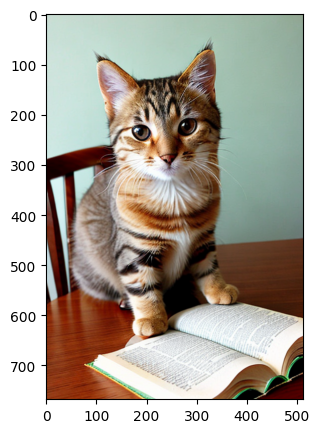

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [9]:
predictor.set_image(image)

In [10]:
input_point = np.array([[200, 200]])
input_label = np.array([1])
# input_point = np.array([[500, 200]])
# input_label = np.array([1])

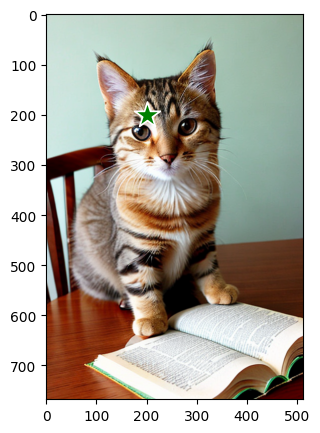

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [12]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [13]:
masks.shape  # (number_of_masks) x H x W

(3, 768, 512)

In [14]:
scores.shape, logits.shape

((3,), (3, 256, 256))

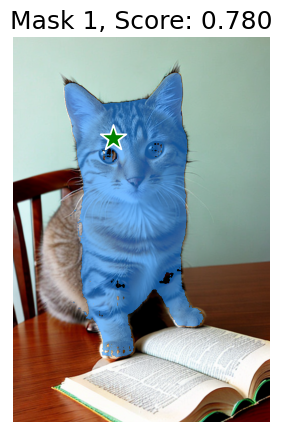

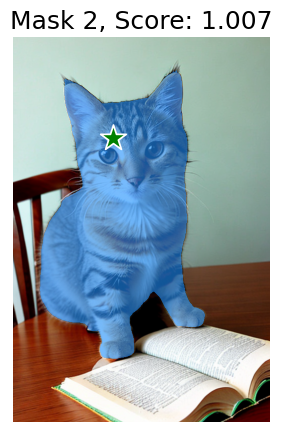

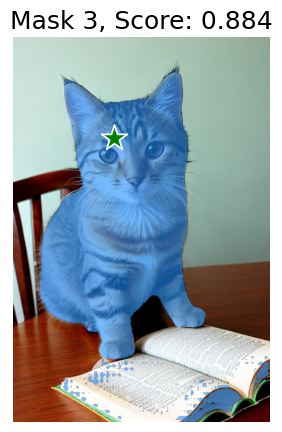

In [15]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [16]:
input_point = np.array([[200, 200], [400, 600]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
logits.shape, mask_input.shape

((3, 256, 256), (256, 256))

In [17]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [18]:
masks.shape


(1, 768, 512)

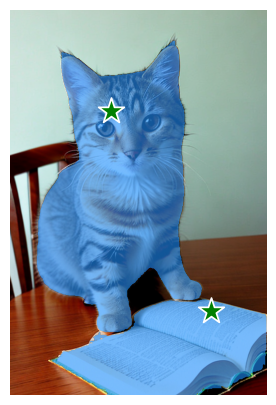

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [20]:
input_point = np.array([[200, 200], [400, 600]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [21]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

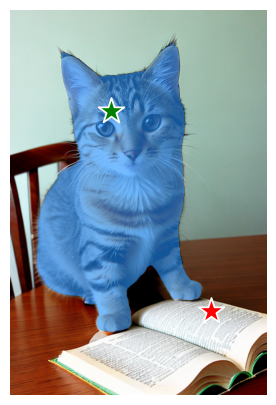

In [22]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [23]:
input_box = np.array([0, 250, 200, 768])


In [24]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

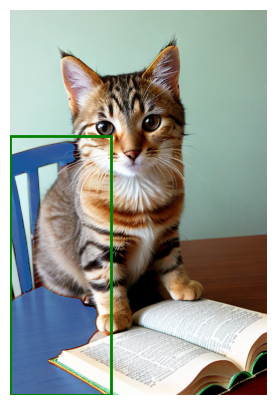

In [25]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [26]:
input_box = np.array([0, 250, 200, 768])
input_point = np.array([[20, 700]])
input_label = np.array([0])

In [27]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

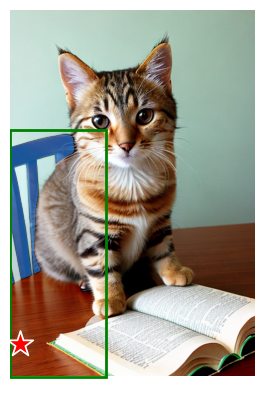

In [28]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [29]:
input_boxes = torch.tensor([
    [0, 250, 150, 600],
    [50, 50, 400, 650],
    [80, 550, 512, 768]
], device=predictor.device)

In [30]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [31]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W


torch.Size([3, 1, 768, 512])

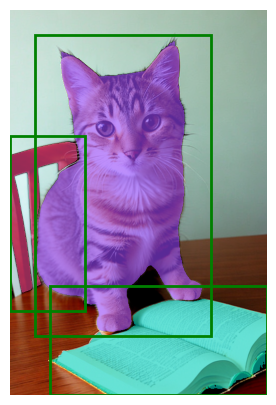

In [32]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [33]:
# image1 = image  # truck.jpg from above
# image1_boxes = torch.tensor([
#     [75, 275, 1725, 850],
#     [425, 600, 700, 875],
#     [1375, 550, 1650, 800],
#     [1240, 675, 1400, 750],
# ], device=sam.device)

# image2 = cv2.imread('images/groceries.jpg')
# image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
# image2_boxes = torch.tensor([
#     [450, 170, 520, 350],
#     [350, 190, 450, 350],
#     [500, 170, 580, 350],
#     [580, 170, 640, 350],
# ], device=sam.device)

In [34]:
# from segment_anything.utils.transforms import ResizeLongestSide
# resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

# def prepare_image(image, transform, device):
#     image = transform.apply_image(image)
#     image = torch.as_tensor(image, device=device.device)
#     return image.permute(2, 0, 1).contiguous()

In [35]:
# batched_input = [
#      {
#          'image': prepare_image(image1, resize_transform, sam),
#          'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
#          'original_size': image1.shape[:2]
#      },
#      {
#          'image': prepare_image(image2, resize_transform, sam),
#          'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
#          'original_size': image2.shape[:2]
#      }
# ]

In [36]:
# batched_output = sam(batched_input, multimask_output=False)


In [37]:
# batched_output[0].keys()


In [38]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 20))

# ax[0].imshow(image1)
# for mask in batched_output[0]['masks']:
#     show_mask(mask.cpu().numpy(), ax[0], random_color=True)
# for box in image1_boxes:
#     show_box(box.cpu().numpy(), ax[0])
# ax[0].axis('off')

# ax[1].imshow(image2)
# for mask in batched_output[1]['masks']:
#     show_mask(mask.cpu().numpy(), ax[1], random_color=True)
# for box in image2_boxes:
#     show_box(box.cpu().numpy(), ax[1])
# ax[1].axis('off')

# plt.tight_layout()
# plt.show()

## everyting

In [39]:
import cv2
image = cv2.imread('cat2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [40]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# predictor = SamPredictor(sam)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [87]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    pred_iou_thresh = 0.98,
    # points_per_side = 32,
)

In [88]:
%%time
masks = mask_generator_.generate(image)

CPU times: user 7.09 s, sys: 16.9 ms, total: 7.11 s
Wall time: 7.17 s


In [89]:
for mask in masks:
  print(mask.keys())


dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
dict_keys(['segmentation', '

In [90]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [91]:
for m in masks[0]['point_coords'] :
  print([float(x) for x in m])
  break

[168.0, 156.0]


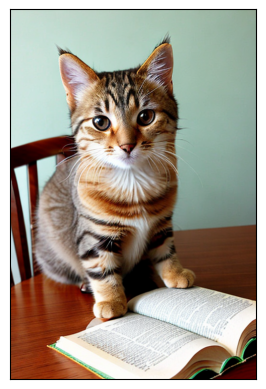

In [92]:
show(torch.tensor(image).permute(2,0,1))

In [93]:
np.array(image).shape

(768, 512, 3)

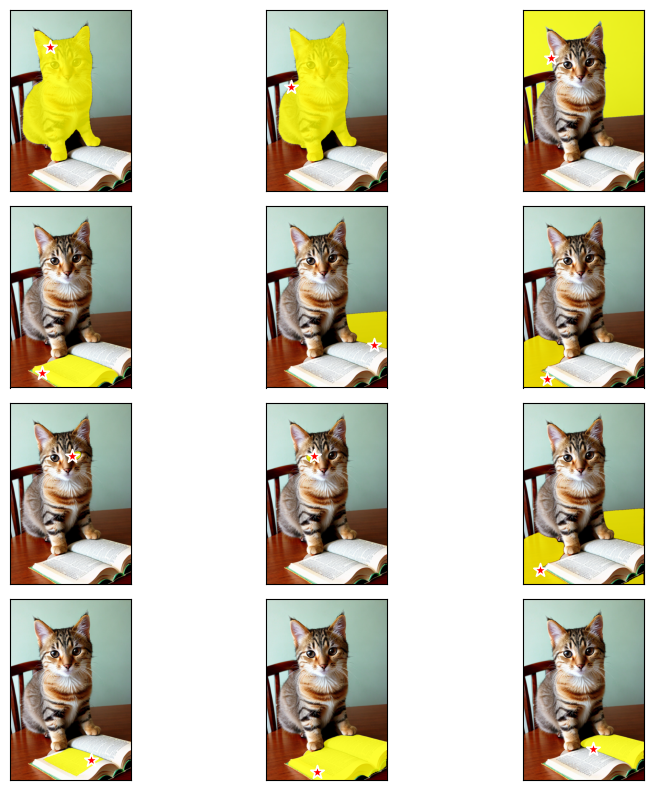

In [94]:
from torchvision.utils import draw_segmentation_masks

n = len(masks)
m = 3

flg, axes = plt.subplots(nrows = (n+m//2)//m, ncols = m, tight_layout=True, figsize=(3*m, 2*(n+m//2)//m))

for i in range(len(masks)) :
  img = torch.tensor(image).permute(2,0,1)
  mask =  torch.tensor(masks[i]['segmentation'])
  x = draw_segmentation_masks(img, mask, colors="yellow")

  axes[i//m, i%m].imshow(x.permute(1,2,0))
  axes[i//m, i%m].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

  px, py = masks[i]['point_coords'][0]
  input_point = np.array([[int(px), int(py)]])
  input_label = np.array([0])
  show_points(input_point, input_label, axes[i//m, i%m], marker_size=100)
  # if i == 6 : break


plt.show()


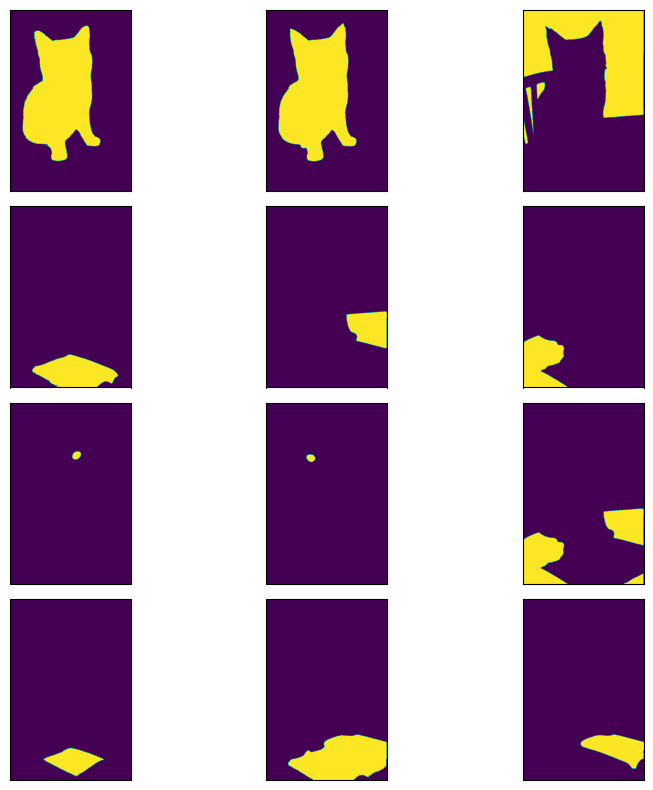

In [95]:

n = len(masks)
m = 3

flg, axes = plt.subplots(nrows = (n+m//2)//m, ncols = m, tight_layout=True, figsize=(3*m, 2*(n+m//2)//m))

for i in range(len(masks)) :
  x = torch.tensor(masks[i]['segmentation']).float()
  axes[i//m, i%m].imshow(x)
  axes[i//m, i%m].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
  # if i == 10 : break


plt.show()


In [96]:
(n+m//2)//m

4

In [97]:
77/3

25.666666666666668